In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchinfo import summary

from src.datasets import BiosensorDataset, create_datasets
from src.model_parts import *
from src.models import *
from src.evaluate import evaluate
from src.utils import *

c:\Users\wittd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
data_path = 'C:/onlab_git/Onlab/data_with_centers/'
train_percent = 0.59
test_percent = 0.215

files = os.listdir(data_path)
train_size = int(train_percent * len(files))
val_size = len(files) - train_size
if test_percent > 0:
    test_size = int(test_percent * len(files))
    val_size = val_size - test_size

print('Train size:', train_size)
print('Validation size:', val_size)
print('Test size:', test_size)


# tran, val, test: train %, test %
# 128, 16, 19: .79, .12
# 112, 24, 27: .69, .17
# 96, 32, 35: .59, .215     this is the best - wandb logs
# 80, 40, 43: .495 .265
# 64, 48, 51: .395 .315
# 48, 48, 67: .3 .415

Train size: 96
Validation size: 32
Test size: 35


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

batch_size = 16
upscale_factor = 1

config = {
    'path': 'C:/onlab_git/Onlab/data_with_centers/',
    'mask_type': bool,
    'augment': False,
    'noise': 0.0,
    'dilation': 0,
    'tiling': True,
    'tiling_ratio': 2,
}

create_dataset_args = {
    'train_percent': 0.59,
    'test_percent': 0.215,
}

calc_config = {
    'biosensor_length': 8,
    'mask_size': 80 * upscale_factor,
    'input_scaling': False,
    'upscale_mode': 'nearest',
}

train_dataset, val_dataset, test_dataset = create_datasets(config, create_dataset_args, calc_config)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Train size:', len(train_dataset))
print('Validation size:', len(val_dataset))
print('Test size:', len(test_dataset))

Using device cuda
Train size: 96
Validation size: 32
Test size: 35


In [ ]:
# tesztelni a nem egyforma hálót pl singele up double down

In [4]:
model = UNet(n_channels=calc_config['biosensor_length'], n_classes=1, down_conv=SingleConv, up_conv=SingleConv, bilinear=False)
# model = UNet8(n_channels=bio_len, n_classes=1, down_conv=DoubleConv, up_conv=DoubleConv, bilinear=False)
# model = UNet8(n_channels=bio_len, n_classes=1, down_conv=TripleConv, up_conv=TripleConv, bilinear=False)
model = model.to(device)
print(model.__class__.__name__)
project_name = "Testing SR models"
# model_name = "UNet_320_triple_conv_bilin"
# model_name = "SRUNet4_80_single_bilin"
model_name = "SRUNet8_80_triple_bilin"

model_summary = summary(model)
print(model_summary.trainable_params)

UNet
15330561


In [5]:
# from src.train import train_model
from src.train_tiling import train_model

try:
    train_model(
        model,
        project_name,
        model_name,
        device,
        train_loader,
        val_loader,
        learning_rate=0.03,
        epochs=5,
        checkpoint_dir='test_saves',
        amp=True,
        wandb_logging=False,
        tile_ratio=config['tiling_ratio'],
    )
except torch.cuda.OutOfMemoryError:
    torch.cuda.empty_cache()
    print('Detected OutOfMemoryError!')

Starting training:
        Epochs:          5
        Batch size:      16
        Learning rate:   0.03
        Training size:   96
        Validation size: 32
        Device:          cuda
        Mixed Precision: True
    


Epoch 1/5: 100%|██████████| 96/96 [00:08<00:00, 11.42img/s, loss (batch)=4.47]


Checkpoint 1 saved!


Epoch 2/5: 100%|██████████| 96/96 [00:08<00:00, 11.83img/s, loss (batch)=5.62]


Checkpoint 2 saved!


Epoch 3/5: 100%|██████████| 96/96 [00:08<00:00, 11.68img/s, loss (batch)=4.29]


Checkpoint 3 saved!


Epoch 4/5: 100%|██████████| 96/96 [00:08<00:00, 11.29img/s, loss (batch)=3.62]


Checkpoint 4 saved!


Epoch 5/5: 100%|██████████| 96/96 [00:08<00:00, 10.72img/s, loss (batch)=3.46]

Checkpoint 5 saved!


In [ ]:
from torchinfo import summary
model_summary = summary(model, depth=4)
print(model_summary)
# print(model_summary.total_params)
# print(model_summary.trainable_params)

In [15]:
def evaluate_after_training(model, val_loader, test_loader, device):
    val_dice_score, val_detection_rate = evaluate(model, val_loader, device)
    dice_score, detection_rate = evaluate(model, test_loader, device)
    print(f'Validation dice score: {val_dice_score}, Detection rate: {val_detection_rate}')
    print(f'Test dice score: {dice_score}, Detection rate: {detection_rate}')


In [ ]:
# Load the checkpoint
checkpoint = torch.load("test_saves/checkpoint_epoch20.pth")
# Get the learning rate and remove it from the checkpoint
lr = checkpoint.pop('learning_rate')
# Load the state dictionary into the model
model.load_state_dict(checkpoint)
# Move the model to the device
model = model.to(device)

evaluate_after_training(model, val_loader, test_loader, device)

In [23]:
# Saving the best model for production
# model = UNet8(n_channels=8, n_classes=1)
# checkpoint = torch.load("checkpoints/checkpoint_8_4_85.pth")
# lr = checkpoint.pop('learning_rate')
# model.load_state_dict(checkpoint)

# torch.jit.script(model).save('saved_models/srunet8_len8_40dice.pth')

In [8]:
def plot_results(bio, mask, prediction, binary_prediction):
    plt.figure(figsize=(30, 10))

    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float32)
    colored_mask[mask == 1] = [1, 0, 0, 1]
    colored_mask[mask == 0] = [0, 0, 0, 0]

    colored_prediction = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float32)
    colored_prediction[binary_prediction == 1] = [0, 0, 1, 1]
    colored_prediction[binary_prediction == 0] = [0, 0, 0, 0]

    plt.subplot(1, 3, 1)
    plt.imshow(bio, cmap='gray')
    plt.imshow(colored_mask, alpha=0.6)
    plt.title('Biosensor with mask')
    
    plt.subplot(1, 3, 2)
    plt.imshow(prediction, cmap='gray')
    plt.imshow(colored_prediction, alpha=0.6)
    plt.title('Prediction with the binary')

    intercection = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float32)
    intercection[(mask == 1) & (binary_prediction == 1)] = [0, 1, 0, 1]

    plt.subplot(1, 3, 3)
    # plt.imshow(bio, cmap='gray')
    plt.imshow(colored_mask)
    plt.imshow(colored_prediction)
    plt.imshow(intercection)
    plt.title('Label and Prediction overlap')
    
    red_patch = mpatches.Patch(color=[1, 0, 0, 1], label='Mask')
    blue_patch = mpatches.Patch(color=[0, 0, 1, 1], label='Prediction')
    green_patch = mpatches.Patch(color=[0, 1, 0, 1], label='Overlap')

    plt.legend(handles=[red_patch, blue_patch, green_patch], loc='upper right', bbox_to_anchor=(1.5, 1))
    
    plt.show()

In [ ]:
for batch_idx, (data, labels) in enumerate(test_loader):
    data = data.to(device)
    labels = labels.to(device)

    predictions = model(data)

    binary_predictions = (torch.nn.functional.sigmoid(predictions) > 0.5)
    binary_predictions = binary_predictions.cpu().detach().numpy()

    labels = labels.cpu().numpy()
    predictions = predictions.cpu().detach().numpy()

    for i in range(len(data)):
        index = (batch_idx * len(data) + i + 1)
        # print(index)
        label = np.squeeze(labels[i])
        binary_prediction = np.squeeze(binary_predictions[i])

        plot_results(data[i][-1].cpu().detach().numpy(), label, np.squeeze(predictions[i]), binary_prediction)

    break


In [53]:
def create_tiles(bio, mask, ratio):
    ch, bh, bw = bio.shape
    mh, mw = mask.shape
    bio_size = bh // ratio
    mask_size = mh // ratio

    bio_tiles = bio.reshape(ch, ratio, bio_size, ratio, bio_size).permute(1, 3, 0, 2, 4).reshape(ratio * ratio, ch, bio_size, bio_size)
    mask_tiles = mask.reshape(ratio, mask_size, ratio, mask_size).permute(0, 2, 1, 3).reshape(ratio * ratio, mask_size, mask_size)
    print(bio_tiles.shape, mask_tiles.shape)

    return bio_tiles, mask_tiles

def merge_tiles(tiles):
    n, h, w = tiles.shape
    ratio = int(np.sqrt(n))
    merged = tiles.reshape(ratio, ratio, h, w).permute(0, 2, 1, 3).reshape(ratio * h, ratio * w)
    return merged

def plot_tiles(bio_tiles, mask_tiles):
    n, ch, h, w = bio_tiles.shape
    ratio = int(np.sqrt(n))

    fig, ax = plt.subplots(ratio, ratio, figsize=(8, 8))
    for i in range(ratio):
        for j in range(ratio):
            ax[i, j].imshow(bio_tiles[j + i * 4, -1], cmap='gray')
            ax[i, j].imshow(mask_tiles[j + i * 4], alpha=0.6)
            ax[i, j].axis('off')
    plt.tight_layout()
    plt.show()

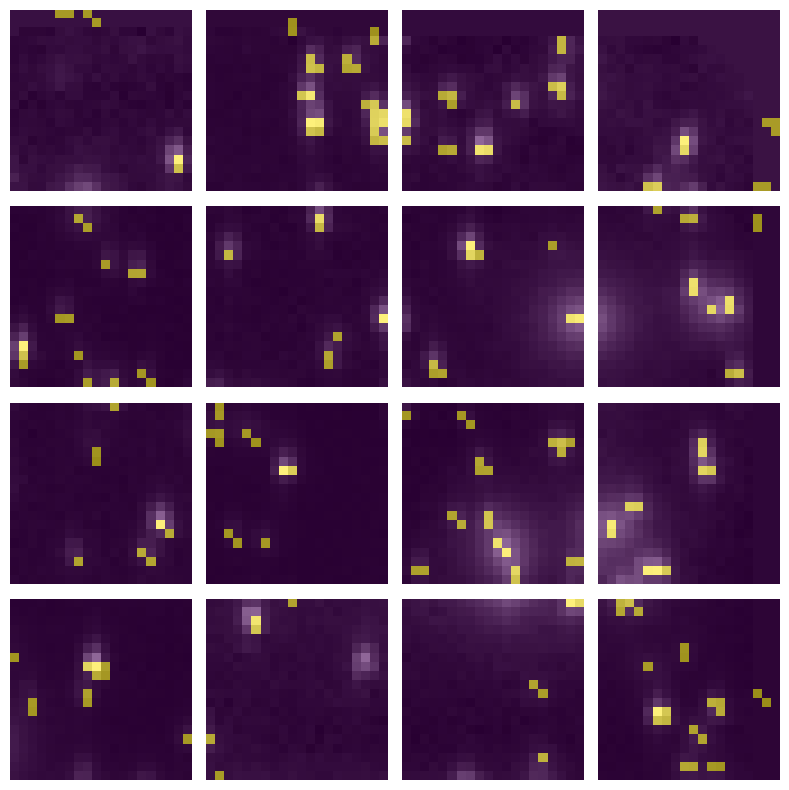

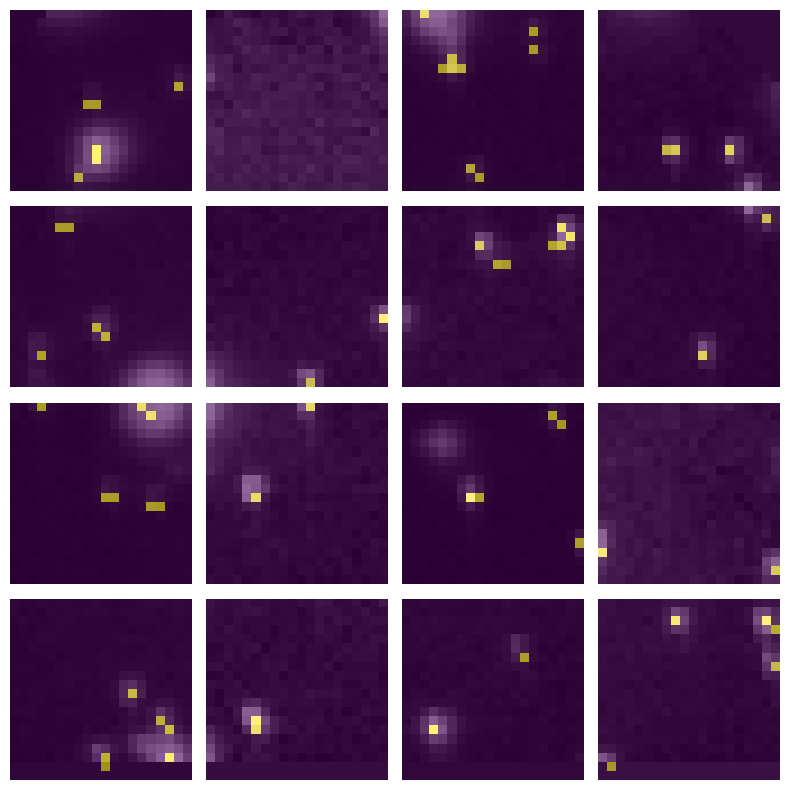

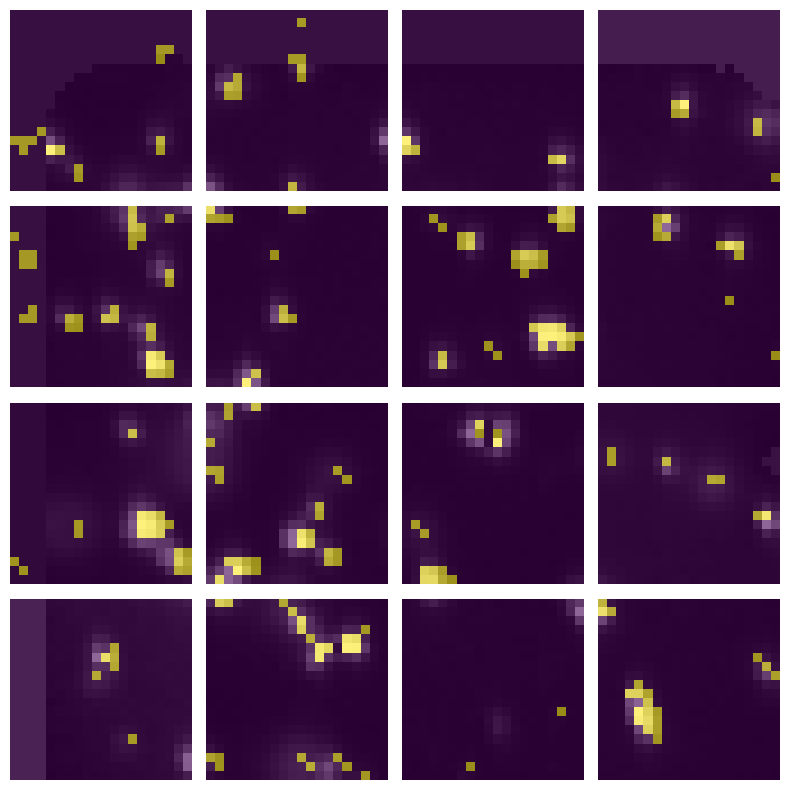

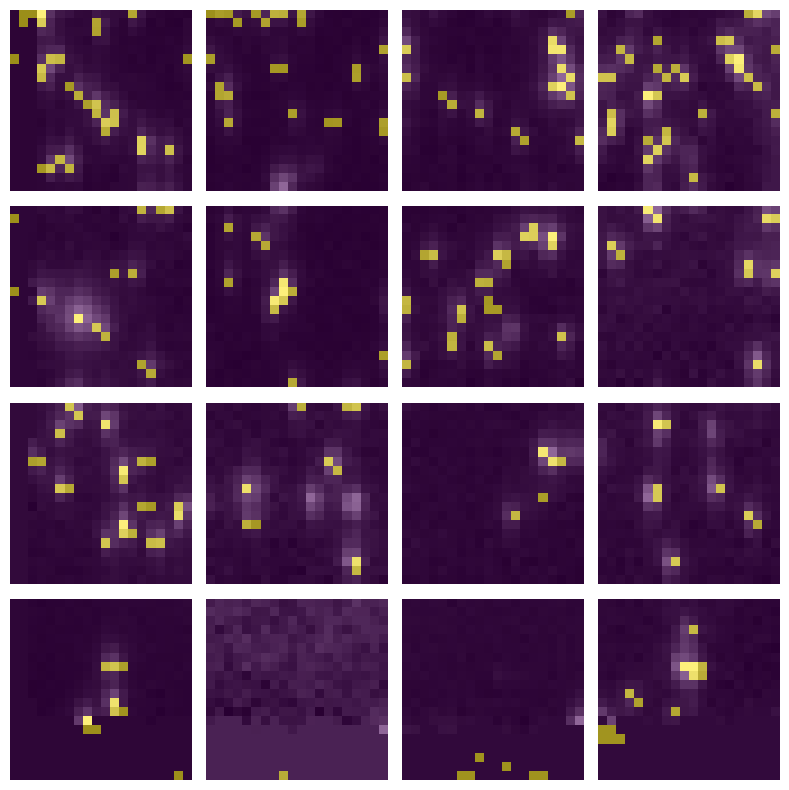

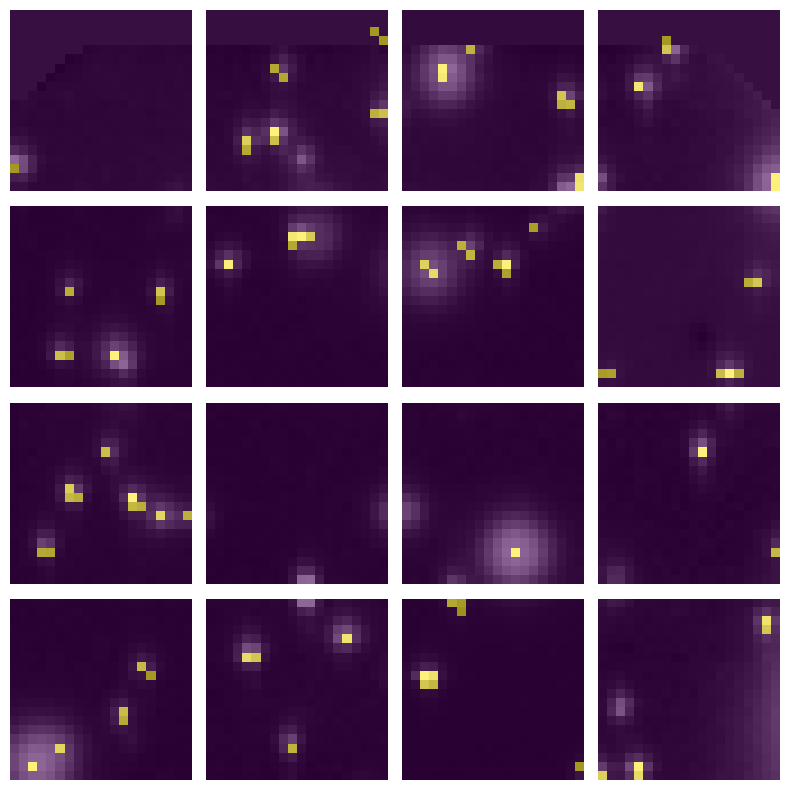

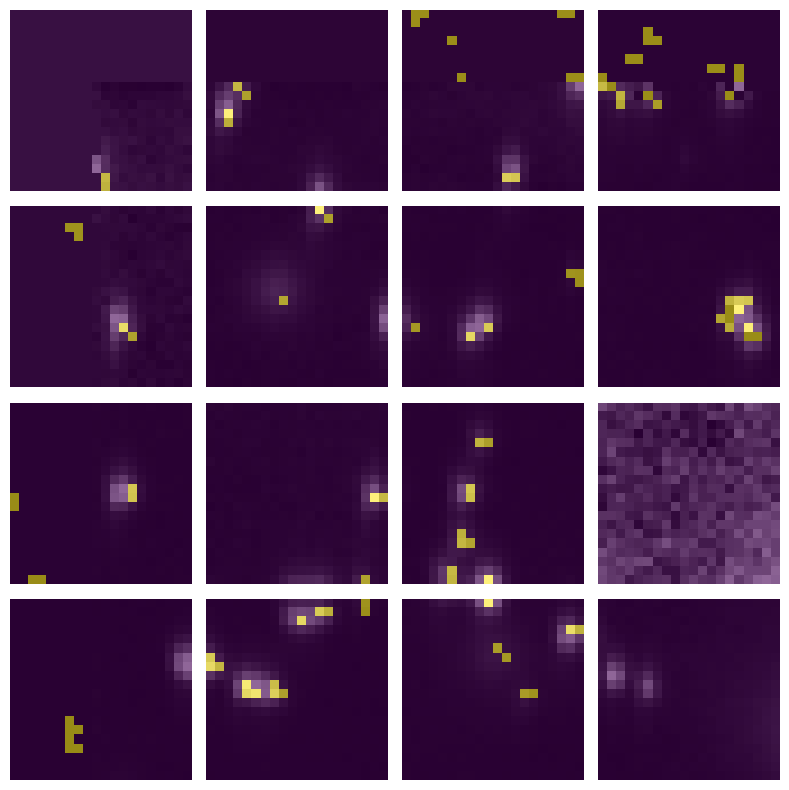

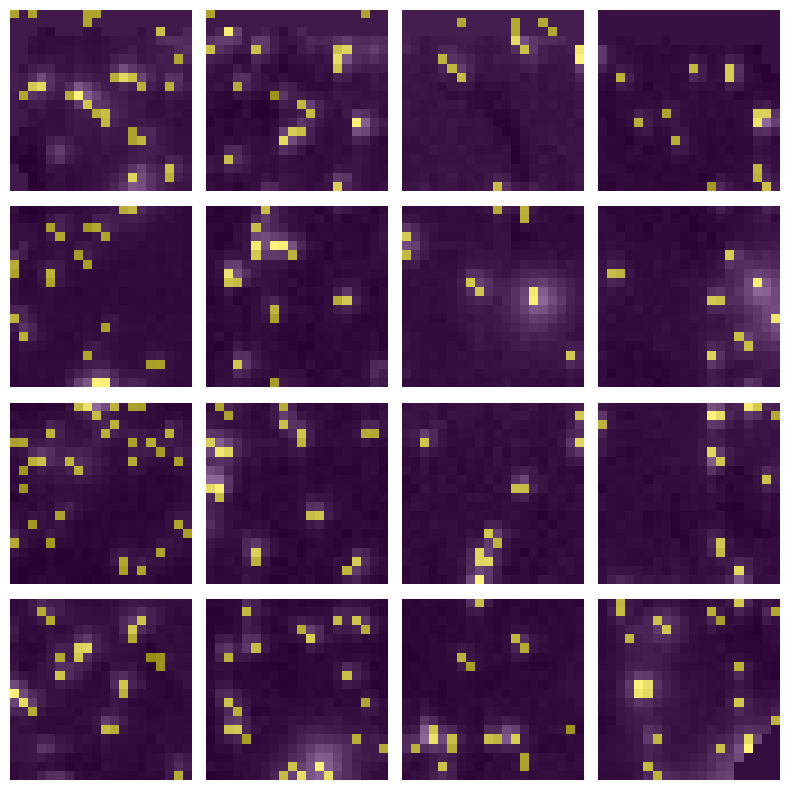

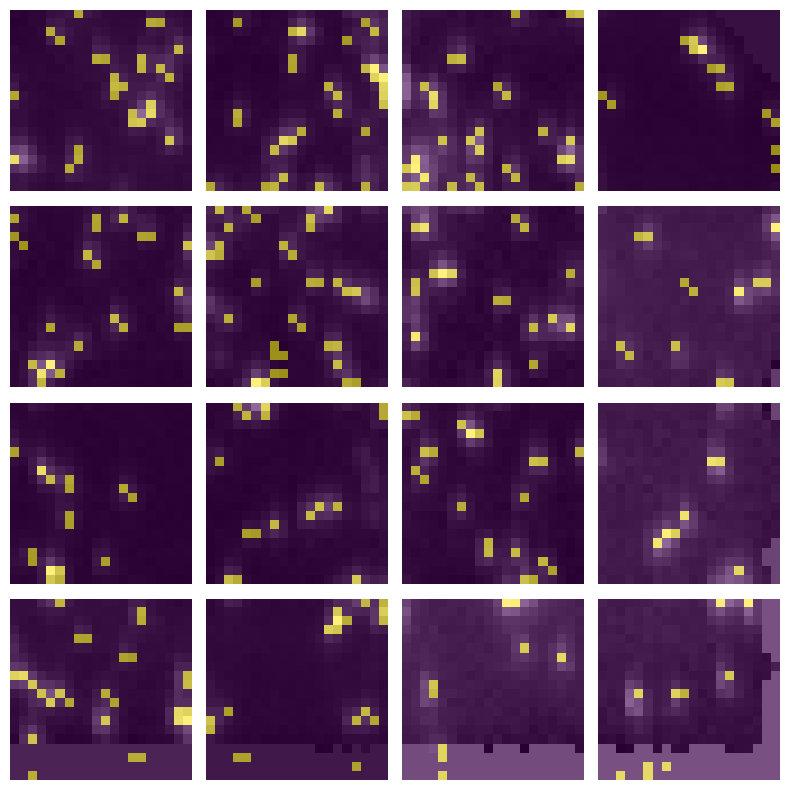

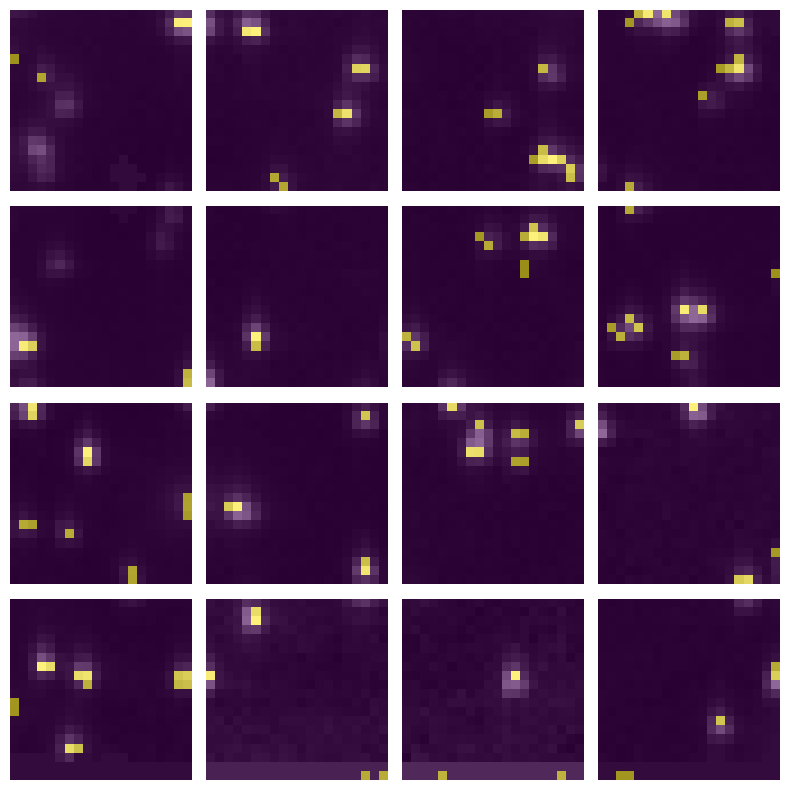

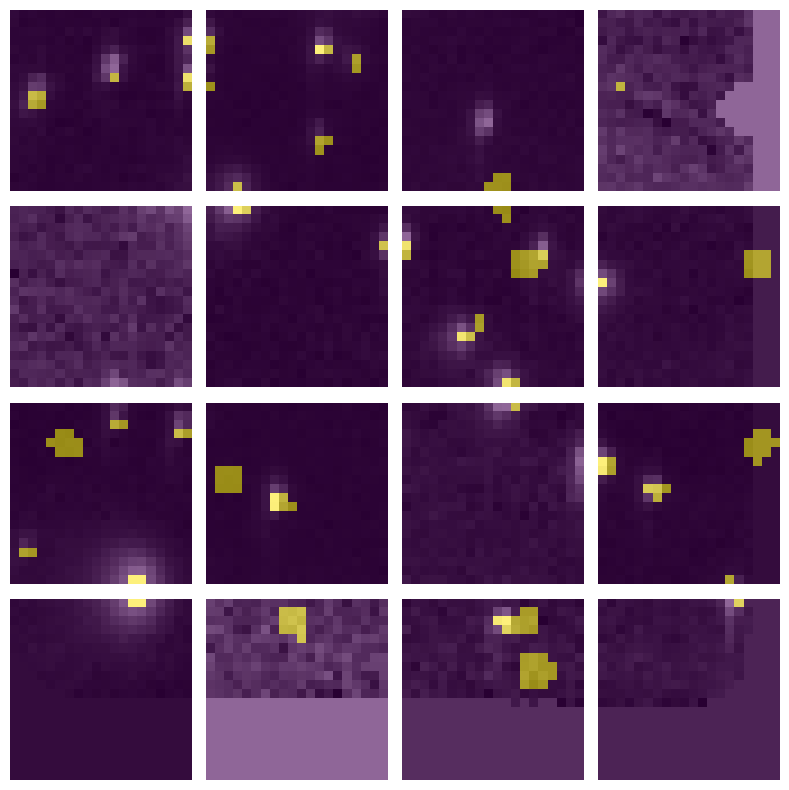

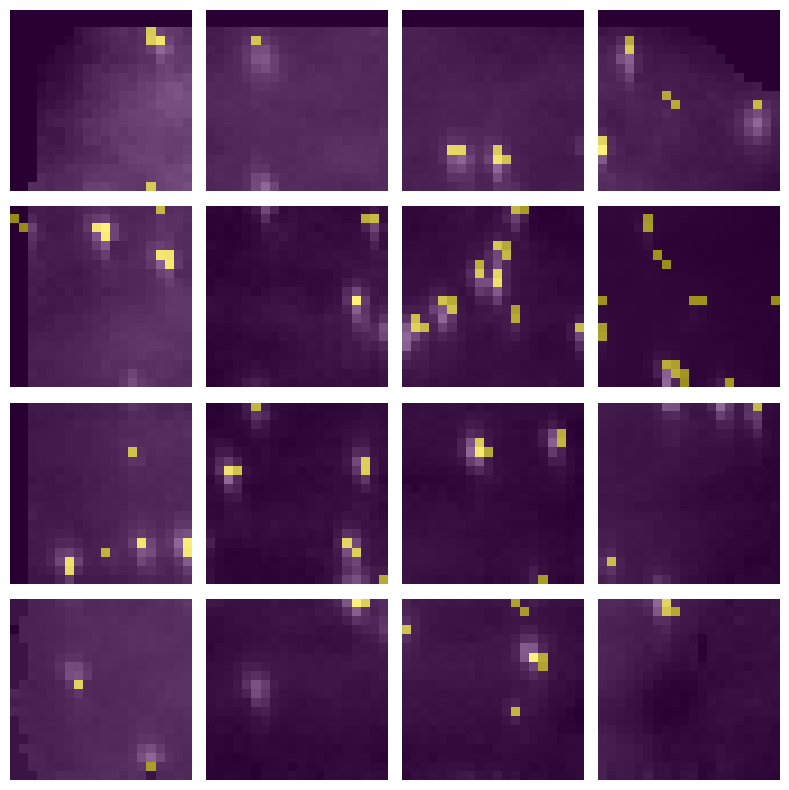

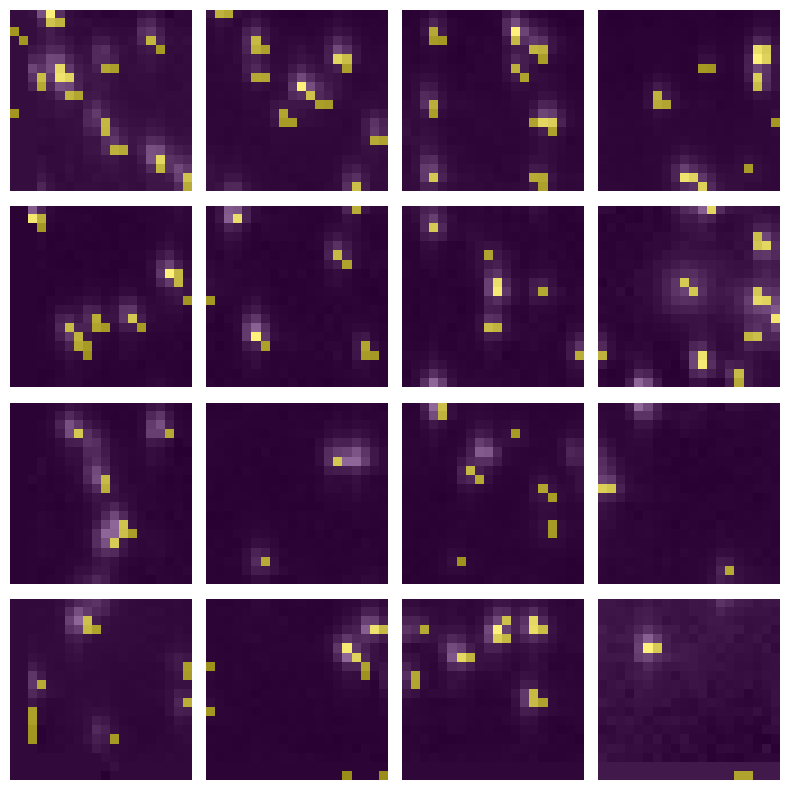

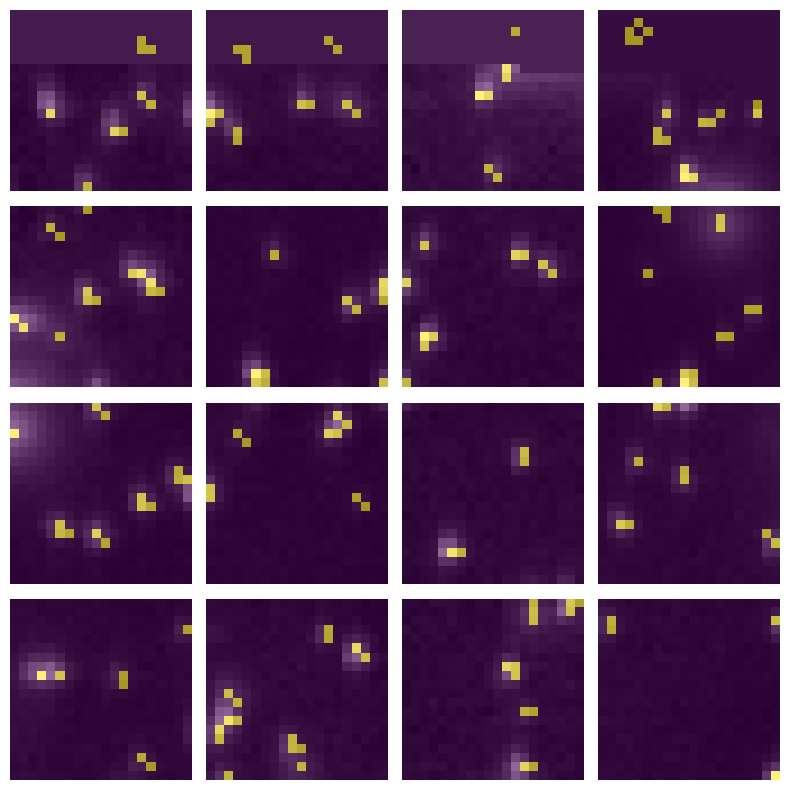

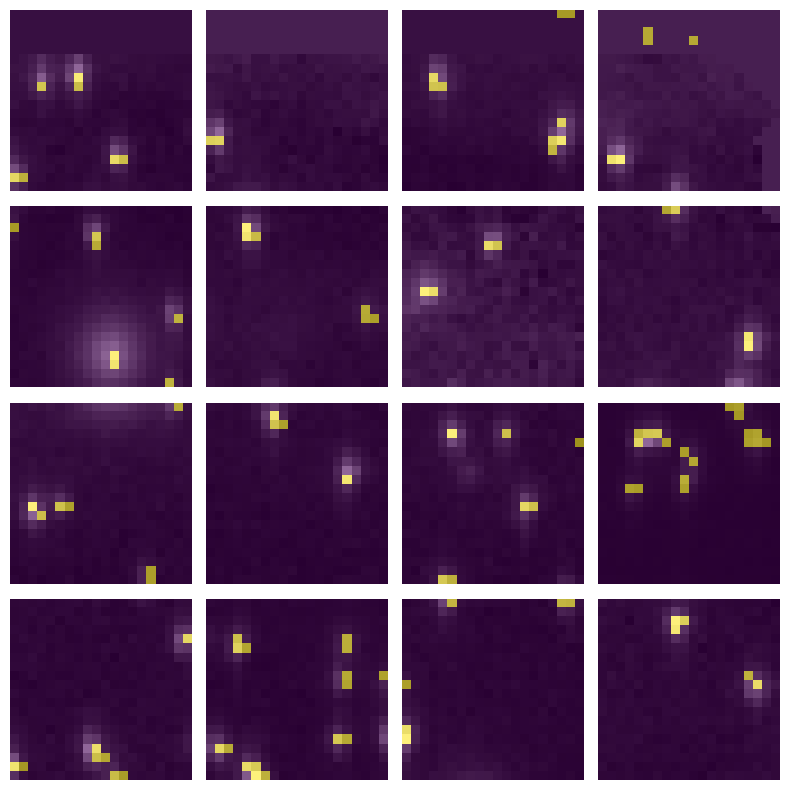

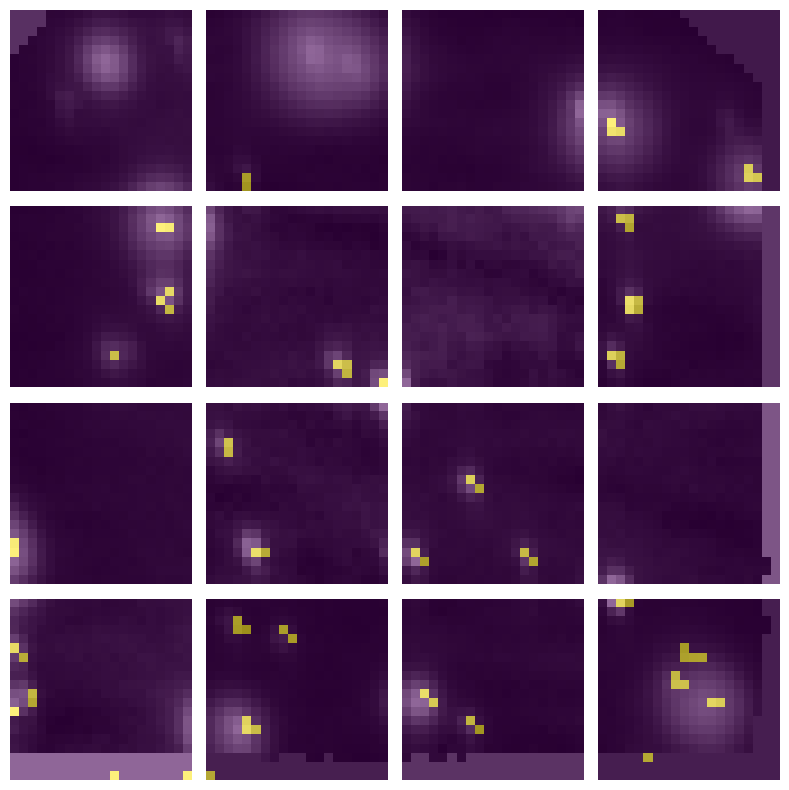

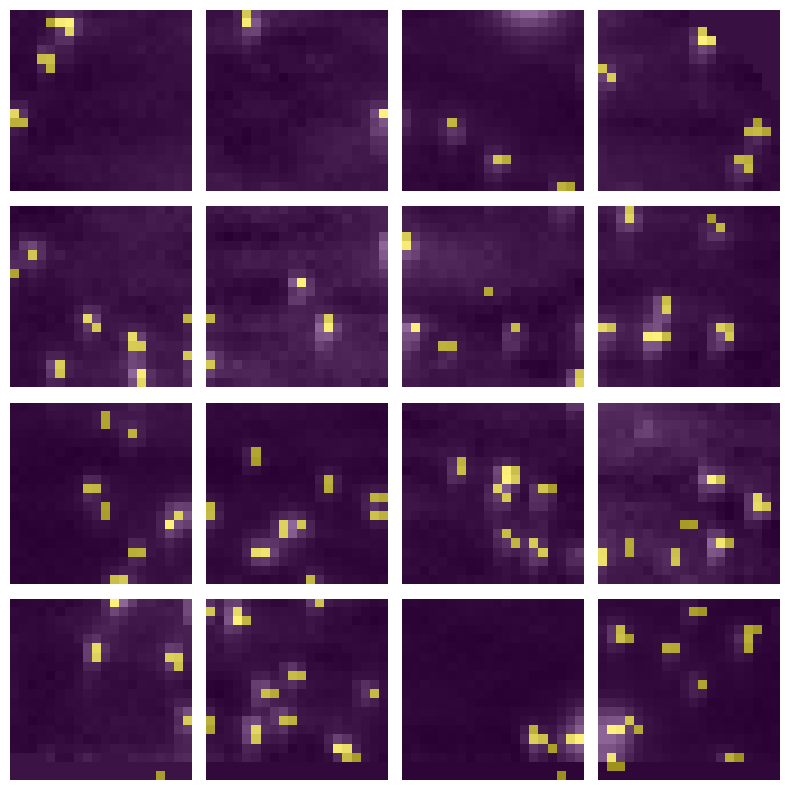

In [54]:
def plot_loader_data(loader, title):
    for batch_idx, (data, labels) in enumerate(loader):
        # Move the data and labels to the CPU
        # data = data.cpu().numpy()
        # labels = labels.cpu().numpy()

        if batch_idx == 1:
            break

        for i in range(batch_size):
            # print(data.shape, labels.shape)
            # mask = merge_tiles(labels[i])
            # bio = merge_tiles(data[i,:,-1])
            # plt.subplots(1, 2, figsize=(8, 8))
            # plt.imshow(bio, cmap='gray')
            # plt.imshow(mask, cmap='gray')
            # plt.show()
            # print(data[i,:,-1].shape, labels[i].shape)

            plot_tiles(data[i], labels[i])

        

plot_loader_data(test_loader, 'Test')

In [ ]:
def plot_loader_data(loader, title):
    for batch_idx, (data, labels) in enumerate(loader):
        # Move the data and labels to the CPU
        data = data.cpu().numpy()
        labels = labels.cpu().numpy()

        if batch_idx == 1:
            break

        # Plot each image in the batch
        for i in range(len(data)):
            index = (batch_idx * len(data) + i + 1)

            plt.figure(figsize=(20, 10))

            # Plot the input image
            plt.subplot(1, 3, 1)
            plt.imshow(data[i][-1], cmap='gray')
            plt.title(f'{title} - Image {index} ')

            # Plot the label
            plt.subplot(1, 3, 2)
            plt.imshow(labels[i], cmap='gray')
            plt.title(f'{title} - Label {index}')

            plt.subplot(1, 3, 3)
            plt.imshow(data[i][-1], cmap='gray')
            plt.imshow(labels[i], cmap='Reds', alpha=0.25)

            plt.show()

plot_loader_data(test_loader, 'Test')